Loading Dataset

In [2]:
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# !unzip '/content/chest-xray-pneumonia.zip'
# !rm -r chest_xray/chest_xray/
# !rm -r /content/chest_xray/__MACOSX

Importing all the libraries 

In [ ]:
# Just for ignoring unnecesary WARNINGS
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.gridspec as gridspec
from plotly import __version__
import cufflinks as cf
from plotly.offline import  download_plotlyjs,init_notebook_mode,iplot
init_notebook_mode(connected=True)
cf.go_offline()

Setting Path Variables

In [ ]:
data_dir = '/content/chest_xray'
test_path = data_dir + '/test/'
train_path = data_dir + '/train/'

Counting the images in train and test set

In [ ]:
print("Training Set")
pneumonia = len(os.listdir(train_path+'PNEUMONIA'))
normal  = len(os.listdir(train_path+'NORMAL'))
print("No of Pneumonia images : ",pneumonia)
print("No of Normal images    : ",normal)
print("Total training images  : ",pneumonia+normal)

Training Set
No of Pneumonia images :  3875
No of Normal images    :  1341
Total training images  :  5216


In [ ]:
print("Testing Test")
pneumonia = len(os.listdir(test_path+'PNEUMONIA'))
normal  = len(os.listdir(test_path+'NORMAL'))
print("No of Pneumonia images",pneumonia)
print("No of Normal images",normal)
print("Total testing images :",pneumonia+normal)

Testing Test
No of Pneumonia images 390
No of Normal images 234
Total testing images : 624


Visulization of Some training and testing Images

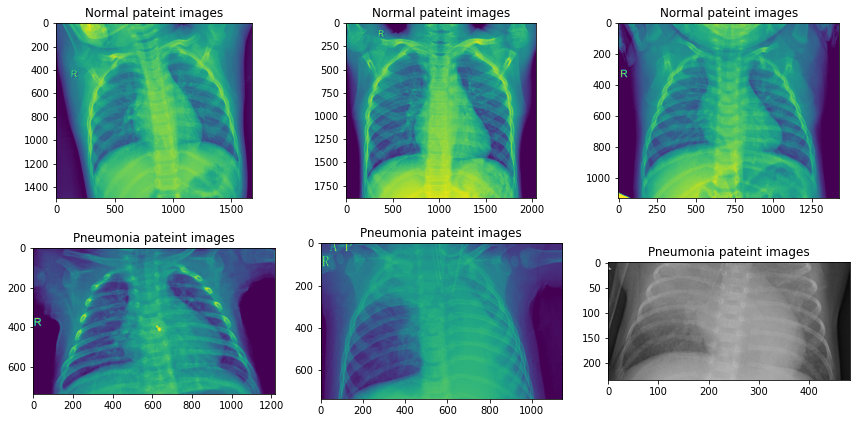

In [ ]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 3, figure=fig)
for i in range(1,4):
  img = os.listdir(train_path+'NORMAL')[i-1]
  ax1 = fig.add_subplot(gs[0, i-1])
  plt.imshow(imread(train_path +'NORMAL/' +img))
  plt.title("Normal pateint images")
  plt.tight_layout()

for i in range(1,4):
  img = os.listdir(train_path+'PNEUMONIA')[i]
  ax1 = fig.add_subplot(gs[1, i-1])
  plt.imshow(imread(train_path +'PNEUMONIA/' +img))
  plt.title("Pneumonia pateint images")
  plt.tight_layout()

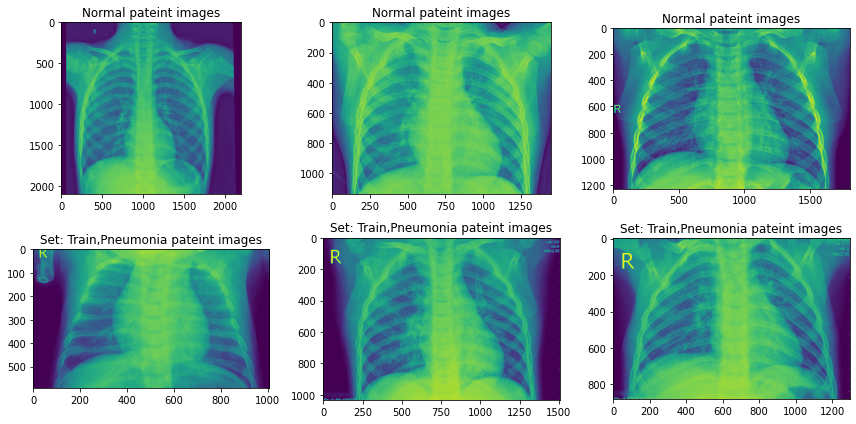

In [ ]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 3, figure=fig)
for i in range(1,4):
  img = os.listdir(test_path+'NORMAL')[i-1]
  ax1 = fig.add_subplot(gs[0, i-1])
  plt.imshow(imread(test_path +'NORMAL/' +img))
  plt.title("Normal pateint images")
  plt.tight_layout()

for i in range(1,4):
  img = os.listdir(test_path+'PNEUMONIA')[i]
  ax1 = fig.add_subplot(gs[1, i-1])
  plt.imshow(imread(test_path +'PNEUMONIA/' +img))
  plt.title("Set: Train,Pneumonia pateint images")
  plt.tight_layout()

Comparing Pneumonia and Normal images

Text(0.5, 1.0, 'Normal')

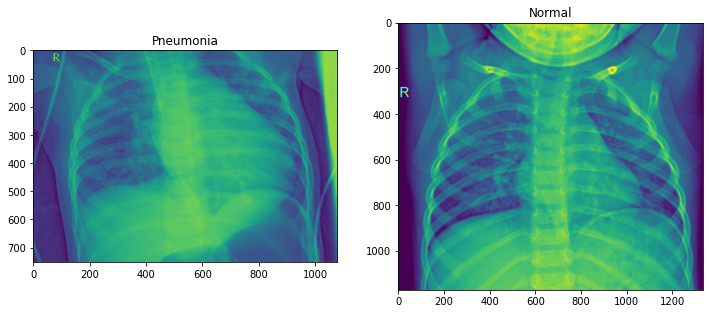

In [ ]:
pneumonia = np.random.choice(os.listdir(train_path + '/PNEUMONIA/'))
normal = np.random.choice(os.listdir(train_path + '/NORMAL/'))

fig = plt.figure(figsize=(12,6))

fig.add_subplot(1,2,1)
plt.imshow(imread(train_path + '/PNEUMONIA/' + pneumonia))
plt.title("Pneumonia")

fig.add_subplot(1,2,2)
plt.imshow(imread(train_path + '/NORMAL/' + normal))
plt.title('Normal')



All the images are not in RGB form, so we are converting it into RGB and setting all the images to the shape of (150,150,3)

In [ ]:
# All the images will be of size (150,150,3)
img_dim = 128

In [ ]:

# Resizing all the Training and Testing images and converting it to RGB
# and later dividing into training and testing in the ratio 60:40.
def data_labels():
      data = []
      labels = []
      for directories in ['/train/','/test/']:
          for subdir in ['/NORMAL/', '/PNEUMONIA/']:
              for img in (os.listdir( data_dir + directories + subdir )):
                  img = plt.imread( data_dir + directories + subdir + img )
                  img = cv2.resize(img, (img_dim,img_dim))

                  # In the datset, not all the images are greyscale, so this in next step we are checking 
                  # if the image is already RGB, we will do nothing in this case and skip this step.

                  if img.shape != (img_dim,img_dim,3):
                      img = np.dstack([img, img, img])
                  
                  # Scaling the image matrix into the value b/w 0 and 1 

                  img = img.astype('float32') / 255


                  if subdir == '/NORMAL/' :
                      label = 0
                  elif subdir == '/PNEUMONIA/' :
                      label = 1

                  
                  data.append(img)
                  labels.append(label)
      return data,labels

Using data shuffling and dividing the data into 70:30 ratio

In [ ]:
data, labels = data_labels()
# Use shuffling for improvement
import random
seed = 42
random.seed(seed)
shuffled_data = list(zip(data, labels))
random.shuffle(shuffled_data)
data, labels = zip(*shuffled_data)

X = np.array(data)
y = np.array(labels)

In [ ]:
# There are 5840 images in total.
# Taking 70:30 ratio for breaking into testing and training
# 70% of 5840 is 4087
breaking_point = 4807
X_train = X[:breaking_point]
y_train = y[:breaking_point] 

X_test = X[breaking_point:]
y_test = y[breaking_point:]

Showing the Counting of images in Train and Test set

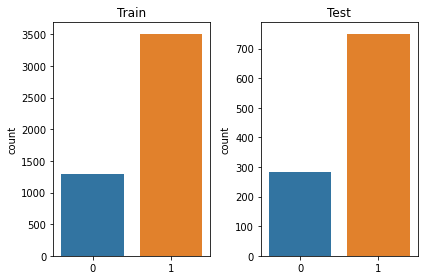

In [ ]:
plt.subplot(1,2,1)
sns.countplot(y_train).set_title('Train')

plt.subplot(1,2,2)
sns.countplot(y_test).set_title('Test')

plt.tight_layout()

Reshaping all the Images for feeding it into ML Algorithms


In [ ]:
print(X_train.shape)
X_train = np.reshape(X_train, (breaking_point,img_dim*img_dim*3))
print(X_train.shape)

(4807, 128, 128, 3)
(4807, 49152)


In [ ]:
print(X_test.shape)
X_test = np.reshape(X_test, (X_test.shape[0],img_dim*img_dim*3))
print(X_test.shape)

(1033, 128, 128, 3)
(1033, 49152)


Initializing the SVM algorithm

In [ ]:
def algo(X,y):
    svm = SVC()
    svm.fit(X, y)
    print('train score', svm.score(X, y))
    print('test score', svm.score(X_test, y_test))
    return svm

We will use Oversampling for balancing our imbalanced data using SMOTE( Synthetic Minority Oversampling Technique)

In [ ]:
def oversampling(X,y):
    sm = SMOTE()
    X, y = sm.fit_resample(X, y)
    return X,y

Drawing out conclusions after prediction using Confusion matrix

In [ ]:
def Confusion_matrix(svm):
      predict = svm.predict(X_test)
      CM = confusion_matrix(predict,y_test)
      from mlxtend.plotting import plot_confusion_matrix
      fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
      plt.show()
      return predict,CM

Getting all the parameter score such as ROC-AUC, Accuracy, Precision, Recall, F1-Score

In [ ]:
def all_para(predict,CM):
    print("ROC-AUC     : ",roc_auc_score(y_test, predict))
    TN, FP, FN, TP = CM.ravel()
    acc = (TP + TN)/(TN+TP+FP+FN)
    print("Accuracy    : ", acc)
    print("Precision   : ",precision_score(y_test, predict))
    print("Recall Score: ",recall_score(y_test, predict))
    print("F1-Score    : " ,f1_score(y_test,predict))
    print()
    print()
    print()
    print()
    df = pd.DataFrame({'columns' : ['ROC-AUC','Accuracy','Precision','Recall','F1-score'],
                   'values':[roc_auc_score(y_test, predict),acc,precision_score(y_test, predict),
                             recall_score(y_test, predict),f1_score(y_test,predict)]})
    df.plot(kind ='scatter',x='columns',y='values')

In [ ]:
# Using Smote
X_smote,y_smote = oversampling(X_train,y_train)

After using SMOTE

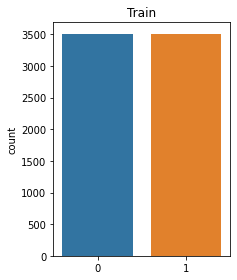

In [ ]:
plt.subplot(1,2,1)
sns.countplot(y_smote).set_title('Train')

plt.tight_layout()
# Both the classes have same number of normal and pneumonia images data

In [ ]:
svm = algo(X_smote,y_smote)

train score 0.9752418895845191
test score 0.9593417231364957


In [ ]:
svm

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

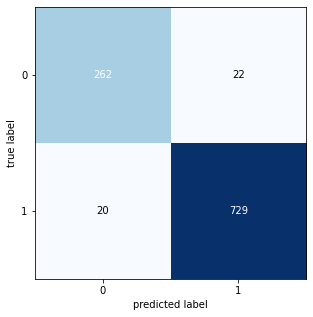

In [ ]:
predict, CM = Confusion_matrix(svm)

ROC-AUC     :  0.9498918699417326
Accuracy    :  0.9593417231364957
Precision   :  0.9732977303070761
Recall Score:  0.9707057256990679
F1-Score    :  0.9720000000000001






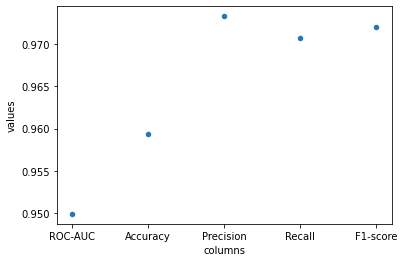

In [ ]:
all_para(predict,CM)